## In-class exercise: implement "accuracy" - number of images correctly labeled

## In-class exercise: split the training data into training & validation, and track validation loss during the training loop. 

Tip: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- How do we know when to stop training? For example, you might stop when the validation loss stops improving.
- Now that we have the basics, we can experiment with more complicated networks. Rather than implement these all by hand, we will move to using existing Python packages next week.
- There are variants of "universal approximation theorems" roughly stating that there exists a nonlinear neural network with one hidden layer (possibly very wide) can fit an "arbitrary" nice/smooth function arbitrarily well. However, we can make the optimization easier with fancier layers than "fully connected," like convolutional layers, which we will learn about next week. 

## Homework: improve the accuracy of this model. 

Update this notebook so that the accuracy is improved. How high can you get it? You could change things directly in the notebook, such as increasing the number of epochs, changing the learning weight, changing the width of the hidden layer, etc. If you're more ambitious, you could also try changing the model definition itself by checking out the associated Python files. For example, you could add more layers to the network. The current notebook has a training accuracy of about 43%, but will vary with randomness.

In [ ]:
!git clone https://github.com/AlexLeeSmith/ai-science-training-series.git
%cd ai-science-training-series/homework/

In [84]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from numpy import power, argmax, float32, prod, int32, arange, zeros, random
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from typing import Tuple, Any
from modules.fc_net import TwoLayerNet

def calc_decay(t, y0, decayRate: float) -> float:
    """
    Calculates the value at a specified time point of an exponential decay function.

    Side Effects: None
    """
    return y0 * ((1.0 - decayRate) ** t)

def sgd(model, gradients, learningRate: float):
    """
    Performs one iteration of stochastic gradient decent (SGD) for each 
    parameter in the model.

    Side Effects:
    - The model's weights will be changed.
    """
    # Iterate over each parameter in the model.
    for key, weights in model.params.items():
        # Get the adjusted weights (gradients) for the current key.
        dw = gradients[key]

        # Apply these gradients to the current weights.
        model.params[key] = weights - learningRate * dw

    return model

def calc_accuracy(model, x, trueValues) -> float:
    """
    Calculates the percentage of matching values between x and trueValues.

    Side Effects: None
    """
    # Get the scores of each x input to each output class.
    scores = model.loss(x) # [x.shape[0], model.num_classes]

    # Select the output class with the highest score for each x input
    predictions = argmax(scores, axis=1)

    # Calculate the percentage of correct predictions.
    accuracy = (trueValues == predictions).sum() / predictions.shape[0]
    
    return accuracy

def get_batch(x, y, yOnehot, batchNum: int, batchSize: int) -> Tuple[Any, Any, Any]:
    """
    Gets a specific batch of the x, y, and yOnehot data.

    Side Effects: None
    """
    # Calculate the offset of the specified batch.
    offset = batchNum * batchSize

    # Get the indices of the specified batch.
    batchRange = range(offset, offset + batchSize)

    # Return the 
    return x[batchRange, :], y[batchRange], yOnehot[batchRange,:]

def shuffle_data(x, y, yOnehot) -> Tuple[Any, Any, Any]:
    """
    Shuffles the x, y, and yOnehot data.

    Side Effects: None
    """
    # Shuffle the indices array.
    indices = arange(x.shape[0])
    random.shuffle(indices)

    # Return the each dataset shuffled using the new indices.
    return x[indices,:], y[indices], yOnehot[indices,:]

def get_mnist(validTrainRatio: float) -> Tuple[Tuple[Any, Any], Tuple[Any, Any], Tuple[Any, Any]]:
    """
    Loads and splits the MNIST dataset into training, validation and testing data.

    Side Effects: None
    """
    # Load and split the MNIST dataset.
    (xTrain, yTrain), (xTest, yTest) = mnist.load_data()

    # Do some pre-processing on the images.
    ## Convert pixel values from integer to float32.
    xTrain = xTrain.astype(float32)
    xTest  = xTest.astype(float32)

    ## Normalize the pixels to be within 0 and 1.
    xTrain /= 255.
    xTest  /= 255.

    ## Flatten each image to a vector.
    xTrain = xTrain.reshape(xTrain.shape[0], prod(xTrain[0,:,:].shape)) # [60000, 28 * 28]
    xTest = xTest.reshape(xTest.shape[0], prod(xTest[0,:,:].shape))

    ## Set the correct classifications as integers.
    yTrain = yTrain.astype(int32) # [60000,] => (0, 1, ..., or 9)
    yTest  = yTest.astype(int32)

    # Split the training data into training and validation.
    xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=validTrainRatio, random_state=42)

    return (xTrain, yTrain), (xValid, yValid), (xTest, yTest)

def run_mlp(validTrainRatio, learningRate, decayRate, numHiddenDim, modelWeightScale, numEpochs, batchSizeTrain):
    nbClasses = 10          # Number of classifications in the MNIST dataset (0-9).
    
    # Get the MNIST dataset (training, validation, and testing).
    (xTrain, yTrain), (xValid, yValid), (xTest, yTest) = get_mnist(validTrainRatio)

    # One-hot encoding ([1, 0, 2] => [[0, 1, 0], [1, 0, 0], [0, 0, 1]]).
    yTrainOnehot = to_categorical(yTrain, nbClasses) # [yTrain.shape[0], nbClasses]
    yValidOnehot = to_categorical(yValid, nbClasses)
    yTestOnehot = to_categorical(yTest, nbClasses)

    # Calculate batches.
    batchesPerEpoch = int(xTrain.shape[0] / batchSizeTrain)
    batchSizeValid = int(xValid.shape[0] / batchesPerEpoch)

    # Generate necessary arrays.
    lossesTrain = zeros(batchesPerEpoch * numEpochs,)
    accTrain = zeros(batchesPerEpoch * numEpochs,)

    lossesValid = zeros(batchesPerEpoch * numEpochs,)
    accValid = zeros(batchesPerEpoch * numEpochs,)

    # Generate the model as a two-layer network.
    model = TwoLayerNet(input_dim=xTrain.shape[1], hidden_dim=numHiddenDim, num_classes=nbClasses, weight_scale=modelWeightScale)

    # Iterate over the training data to update the model's weights.
    batchCount = 0
    for curEpoch in range(0, numEpochs):
        # Decay the learning rate.
        lrNew = calc_decay(curEpoch, learningRate, decayRate)

        for curBatch in range(0, batchesPerEpoch):
            # Get the next batch of data (training and validation).
            xTrainBatch, yTrainBatch, yTrainOnehotBatch = get_batch(xTrain, yTrain, yTrainOnehot, curBatch, batchSizeTrain)
            xValidBatch, yValidBatch, yValidOnehotBatch = get_batch(xValid, yValid, yValidOnehot, curBatch, batchSizeValid)
        
            # Calculate and save the losses.
            lossesTrain[batchCount], gradientsTrain = model.loss(xTrainBatch, yTrainOnehotBatch)
            lossesValid[batchCount], gradientsValid = model.loss(xValidBatch, yValidOnehotBatch)

            # Update the model's weights.
            model = sgd(model, gradientsTrain, lrNew)

            # Calculate and save the accuracies.
            accTrain[batchCount] = calc_accuracy(model, xTrainBatch, yTrainBatch)
            accValid[batchCount] = calc_accuracy(model, xValidBatch, yValidBatch)

            # Increment the batch count.
            batchCount += 1
    
        # Shuffle the data so that we get a new set of batches.
        xTrain, yTrain, yTrainOnehot = shuffle_data(xTrain, yTrain, yTrainOnehot)
        xValid, yValid, yValidOnehot = shuffle_data(xValid, yValid, yValidOnehot)

    return (lossesTrain, accTrain), (lossesValid, accValid), batchCount

Training:   Loss = 0.0570 Accuracy = 0.9902
Validation: Loss = 0.0939 Accuracy = 0.9684
Mean:       Loss = 0.0755 Accuracy = 0.9793
Gap:        Loss = 0.0369 Accuracy = 0.0219


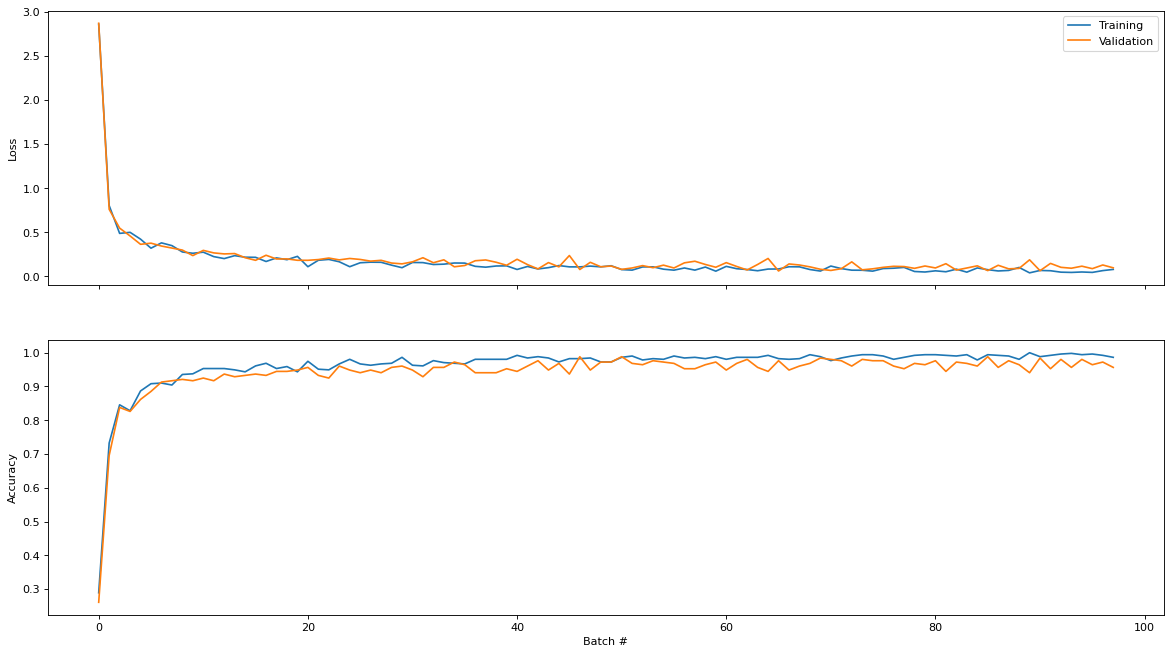

In [100]:
learningRate = 0.8      # Initial rate at which the model learns from each epoch.
decayRate = 0.0         # Rate at which the learning rate decays.
numHiddenDim = 300      # Number of nodes in the hidden layer.
modelWeightScale = 0.1  # Standard deviation for random initialization of the model weights.
numEpochs = 10          # Number of times the entire dataset will be iterated over.
batchSizeTrain = 512    # Size of each training data batch.
validTrainRatio = 0.33  # The ratio of validation data to training data.

(lossesTrain, accTrain), (lossesValid, accValid), batchCount = run_mlp(validTrainRatio, learningRate, decayRate, numHiddenDim, modelWeightScale, numEpochs, batchSizeTrain)

# Output the results.
print("Training:   Loss = %.4f Accuracy = %.4f" % (lossesTrain[batchCount - 1], accTrain[batchCount - 1]))
print("Validation: Loss = %.4f Accuracy = %.4f" % (lossesValid[batchCount - 1], accValid[batchCount - 1]))
print("===========================================")
print("Mean:       Loss = %.4f Accuracy = %.4f" 
      % ((lossesValid[batchCount - 1] + lossesTrain[batchCount - 1]) / 2, (accValid[batchCount - 1] + accTrain[batchCount - 1]) / 2))
print("Gap:        Loss = %.4f Accuracy = %.4f" 
      % (abs(lossesValid[batchCount - 1] - lossesTrain[batchCount - 1]), abs(accValid[batchCount - 1] - accTrain[batchCount - 1])))
fig, ax = pyplot.subplots(2, 1, figsize=(18, 10), dpi=80, sharex=True) # Create a 2 by 1 plot grid.

## Plot the loss history.
step = (batchCount // 100) + 1
ax[0].set_ylabel('Loss')
ax[0].plot(lossesTrain[::step], label='Training')
ax[0].plot(lossesValid[::step], label='Validation')
ax[0].legend()

## Plot the accuracy history.
ax[1].set_xlabel('Batch #')
ax[1].set_ylabel('Accuracy')
ax[1].plot(accTrain[::step], label='Training')
ax[1].plot(accValid[::step], label='Validation')
pass